In [1]:
# --- Core Libraries ---
import os
import random
import shutil
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# --- Machine Learning and Image Processing ---
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import plot_model

# --- Scikit-learn for Evaluation ---
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import normalize

In [ ]:

DATASET_PATH = 'C:/Users/premy/Documents/uni/raml/Code/MLP-Siamese-Network/Face Dataset/0sub'
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32 # Reduced for a smaller dataset
EMBEDDING_DIM = 128

In [12]:
def load_and_preprocess_image(image_path, size=IMAGE_SIZE):
    """Loads an image, resizes it, and converts to a numpy array."""
    img = load_img(image_path, target_size=size)
    return img_to_array(img)

def create_train_val_split_from_map(dataset_path, val_split=0.2):
    """
    Creates train/validation splits by dividing the images within each identity folder.
    Returns two dictionaries: train_map and val_map.
    """
    identity_paths = {}
    for person_name in os.listdir(dataset_path):
        person_dir = os.path.join(dataset_path, person_name)
        if os.path.isdir(person_dir):
            identity_paths[person_name] = [os.path.join(person_dir, img) for img in os.listdir(person_dir)]

    train_map = {}
    val_map = {}
    
    print("Splitting images for each identity...")
    for person, images in identity_paths.items():
        if len(images) < 2:
            print(f"Skipping {person}, not enough images.")
            continue
        
        train_imgs, val_imgs = train_test_split(images, test_size=val_split, random_state=42)
        train_map[person] = train_imgs
        val_map[person] = val_imgs
        print(f"- {person}: {len(train_imgs)} train, {len(val_imgs)} val")
        
    return train_map, val_map

# Create the training and validation maps
train_map, val_map = create_train_val_split_from_map(DATASET_PATH)

print(f"\nTotal identities for training: {len(train_map)}")
print(f"Total identities for validation: {len(val_map)}")

Splitting images for each identity...
- 0: 3 train, 1 val
- 1: 1 train, 1 val
- 10: 3 train, 1 val
- 11: 1 train, 1 val
- 12: 2 train, 1 val
- 13: 2 train, 1 val
- 14: 1 train, 1 val
- 15: 1 train, 1 val
- 16: 1 train, 1 val
- 17: 9 train, 3 val
- 18: 1 train, 1 val
- 19: 4 train, 1 val
- 2: 1 train, 1 val
- 20: 1 train, 1 val
- 21: 2 train, 1 val
- 22: 1 train, 1 val
- 23: 4 train, 1 val
- 24: 2 train, 1 val
- 25: 2 train, 1 val
- 26: 1 train, 1 val
- 27: 4 train, 1 val
- 28: 1 train, 1 val
- 29: 4 train, 1 val
- 3: 3 train, 1 val
- 30: 1 train, 1 val
- 31: 1 train, 1 val
- 32: 4 train, 2 val
- 33: 1 train, 1 val
- 34: 1 train, 1 val
- 35: 3 train, 1 val
- 36: 1 train, 1 val
- 37: 2 train, 1 val
- 38: 31 train, 8 val
- 39: 3 train, 1 val
- 4: 3 train, 1 val
- 40: 3 train, 1 val
- 41: 3 train, 1 val
- 42: 1 train, 1 val
- 43: 2 train, 1 val
- 44: 1 train, 1 val
- 45: 1 train, 1 val
- 46: 1 train, 1 val
- 47: 2 train, 1 val
- 48: 1 train, 1 val
- 49: 1 train, 1 val
- 5: 2 train, 1 val
-

In [56]:
def get_triplets(identity_name, identity_map):
    """Generates a single triplet from a given identity map."""
    all_identities = list(identity_map.keys())
    # Check if there are at least 2 images for the anchor/positive
    if len(identity_map[identity_name]) < 2:
        # Skip this identity and choose another one with at least 2 images
        valid_identities = [name for name in all_identities if len(identity_map[name]) >= 2]
        if not valid_identities:
            raise ValueError("No identity has at least 2 images for triplet selection.")
        identity_name = np.random.choice(valid_identities)
    anchor_path, positive_path = np.random.choice(identity_map[identity_name], 2, replace=False)
    # For negative, ensure there is at least one image in the negative identity
    negative_candidates = [name for name in all_identities if name != identity_name and len(identity_map[name]) > 0]
    if not negative_candidates:
        raise ValueError("No valid negative identities found.")
    negative_identity_name = np.random.choice(negative_candidates)
    negative_path = np.random.choice(identity_map[negative_identity_name])
    return (
        load_and_preprocess_image(anchor_path),
        load_and_preprocess_image(positive_path),
        load_and_preprocess_image(negative_path)
    )

def triplet_generator(identity_map, batch_size=BATCH_SIZE):
    """Yields batches of triplets from the provided identity map."""
    identity_names = list(identity_map.keys())
    while True:
        anchors, positives, negatives = [], [], []
        for _ in range(batch_size):
            identity_name = np.random.choice(identity_names)
            anchor, positive, negative = get_triplets(identity_name, identity_map)
            anchors.append(anchor)
            positives.append(positive)
            negatives.append(negative)
        # Yield a dummy label array instead of None to avoid shape errors
        yield (np.array(anchors) / 255.0, np.array(positives) / 255.0, np.array(negatives) / 255.0), np.zeros((batch_size, 1))

def get_pairs(identity_name, identity_map, is_positive):
    """Generates a single pair from a given identity map."""
    all_identities = list(identity_map.keys())
    if is_positive:
        img1_path, img2_path = np.random.choice(identity_map[identity_name], 2, replace=False)
        label = 1.0
    else:
        img1_path = np.random.choice(identity_map[identity_name])
        negative_identity_name = np.random.choice([name for name in all_identities if name != identity_name])
        img2_path = np.random.choice(identity_map[negative_identity_name])
        label = 0.0
    return load_and_preprocess_image(img1_path), load_and_preprocess_image(img2_path), label

def pair_generator(identity_map, batch_size=BATCH_SIZE):
    """Yields batches of pairs from the provided identity map."""
    identity_names = list(identity_map.keys())
    while True:
        img1s, img2s, labels = [], [], []
        for _ in range(batch_size // 2):
            # Create a positive pair
            identity_name_pos = np.random.choice(identity_names)
            img1, img2, label = get_pairs(identity_name_pos, identity_map, is_positive=True)
            img1s.append(img1); img2s.append(img2); labels.append(label)

            # Create a negative pair
            identity_name_neg = np.random.choice(identity_names)
            img1, img2, label = get_pairs(identity_name_neg, identity_map, is_positive=False)
            img1s.append(img1); img2s.append(img2); labels.append(label)

        yield (np.array(img1s) / 255.0, np.array(img2s) / 255.0), np.array(labels)


def triplet_loss(margin=0.5):
    def loss(y_true, y_pred):
        anchor, positive, negative = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
        loss_value = tf.maximum(ap_distance - an_distance + margin, 0.0)
        return tf.reduce_mean(loss_value)
    return loss

def contrastive_loss(margin=1.0):
    def loss(y_true, y_pred):
        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - y_pred, 0))
        return tf.reduce_mean(tf.cast(y_true, tf.float32) * square_pred + (1 - tf.cast(y_true, tf.float32)) * margin_square)
    return loss



def build_base_cnn(input_shape, embedding_dim=EMBEDDING_DIM):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(embedding_dim, activation=None)(x)
    x = tf.keras.layers.Lambda(lambda t: tf.math.l2_normalize(t, axis=1))(x)
    return Model(inputs, x, name="Embedding_CNN")



In [29]:
# Cell 7 (Modified for a quick test run)

embedding_cnn_triplet = build_base_cnn(input_shape=(*IMAGE_SIZE, 3))
anchor_input = Input((*IMAGE_SIZE, 3))
positive_input = Input((*IMAGE_SIZE, 3))
negative_input = Input((*IMAGE_SIZE, 3))

from tensorflow.keras.layers import Lambda

def stack_embeddings(inputs):
    anchor_emb, positive_emb, negative_emb = inputs
    return tf.stack([anchor_emb, positive_emb, negative_emb], axis=1)

output = Lambda(stack_embeddings)(
    [embedding_cnn_triplet(anchor_input), embedding_cnn_triplet(positive_input), embedding_cnn_triplet(negative_input)]
)
siamese_model_triplet = Model([anchor_input, positive_input, negative_input], output)
siamese_model_triplet.compile(optimizer=Adam(0.0001), loss=triplet_loss(margin=0.5))

print("--- Starting a short test training run ---")

history_triplet = siamese_model_triplet.fit(
    triplet_generator(train_map, batch_size=BATCH_SIZE),
    steps_per_epoch=20,  # <-- REDUCED from 50
    epochs=5,            # <-- REDUCED from 15
    validation_data=triplet_generator(val_map, batch_size=BATCH_SIZE),
    validation_steps=10
)

print("--- Test run completed successfully! ---")
embedding_cnn_triplet.save_weights("embedding_cnn_triplet.weights.h5")

--- Starting a short test training run ---
Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 772ms/step - loss: 0.1891 - val_loss: 0.4729
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 838ms/step - loss: 0.0249 - val_loss: 0.4734
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 764ms/step - loss: 0.0092 - val_loss: 0.4535
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 765ms/step - loss: 0.0065 - val_loss: 0.4302
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 779ms/step - loss: 0.0019 - val_loss: 0.3831
--- Test run completed successfully! ---


In [35]:
embedding_cnn_contrastive = build_base_cnn(input_shape=(*IMAGE_SIZE, 3))
input_1 = Input((*IMAGE_SIZE, 3)); input_2 = Input((*IMAGE_SIZE, 3))
embedding_1 = embedding_cnn_contrastive(input_1); embedding_2 = embedding_cnn_contrastive(input_2)
distance = tf.keras.layers.Lambda(lambda x: tf.sqrt(tf.reduce_sum(tf.square(x[0] - x[1]), axis=1, keepdims=True)))([embedding_1, embedding_2])
siamese_model_contrastive = Model(inputs=[input_1, input_2], outputs=distance)
siamese_model_contrastive.compile(optimizer=Adam(0.0001), loss=contrastive_loss(margin=1.0))

# For training, reduce steps_per_epoch and epochs for a quicker test
# Filter train and val maps to only include identities with at least 2 images
valid_train_map = {k: v for k, v in train_map.items() if len(v) >= 2}
valid_val_map = {k: v for k, v in val_map.items() if len(v) >= 2}

print(f"Training with {len(valid_train_map)} identities (filtered from {len(train_map)})")
print(f"Validating with {len(valid_val_map)} identities (filtered from {len(val_map)})")

history_contrastive = siamese_model_contrastive.fit(
    pair_generator(valid_train_map, batch_size=BATCH_SIZE),
    steps_per_epoch=20,  # Reduced from 50
    epochs=5,            # Reduced from 15
    validation_data=pair_generator(valid_val_map, batch_size=BATCH_SIZE),
    validation_steps=10,
    verbose=1
)
embedding_cnn_contrastive.save_weights("embedding_cnn_contrastive.weights.h5")

Training with 39 identities (filtered from 71)
Validating with 10 identities (filtered from 71)
Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 493ms/step - loss: 0.4039 - val_loss: 0.2832
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 546ms/step - loss: 0.1144 - val_loss: 0.2760
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 630ms/step - loss: 0.0652 - val_loss: 0.2592
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 573ms/step - loss: 0.0478 - val_loss: 0.2444
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 551ms/step - loss: 0.0253 - val_loss: 0.2255


In [37]:
def build_mlp_embedding(input_shape, embedding_dim=EMBEDDING_DIM):
    inputs = Input(shape=input_shape)
    x = Flatten()(inputs)
    x = Dense(512, activation='relu')(x); x = BatchNormalization()(x); x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x); x = BatchNormalization()(x); x = Dropout(0.5)(x)
    x = Dense(embedding_dim, activation=None)(x)
    x = tf.keras.layers.Lambda(lambda t: tf.math.l2_normalize(t, axis=1))(x)
    return Model(inputs, x, name="Embedding_MLP")

def build_efficientnet_embedding(input_shape, embedding_dim=EMBEDDING_DIM):
    base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape, pooling='avg')
    base_model.trainable = False
    inputs = Input(shape=input_shape)
    x = tf.keras.applications.efficientnet.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = Dense(embedding_dim, activation=None)(x)
    x = tf.keras.layers.Lambda(lambda t: tf.math.l2_normalize(t, axis=1))(x)
    return Model(inputs, x, name="Embedding_EfficientNet")

In [45]:
%pip install -U ipywidgets
%pip install -U tqdm
from tqdm.notebook import tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [49]:

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

def create_test_pairs(identity_map, num_pairs=200):
    """Creates a balanced set of test pairs from the validation map."""
    img1s, img2s, labels = [], [], []
    identity_names = list(identity_map.keys())
    
    for _ in tqdm(range(num_pairs), desc="Creating test pairs"):
        # Create a positive pair
        if len(identity_names) > 0:
            pos_identity = np.random.choice(identity_names)
            if len(identity_map[pos_identity]) >= 2:
                img1, img2, label = get_pairs(pos_identity, identity_map, is_positive=True)
                img1s.append(img1); img2s.append(img2); labels.append(label)

        # Create a negative pair
        if len(identity_names) > 1:
            neg_identity = np.random.choice(identity_names)
            img1, img2, label = get_pairs(neg_identity, identity_map, is_positive=False)
            img1s.append(img1); img2s.append(img2); labels.append(label)

    return np.array(img1s) / 255.0, np.array(img2s) / 255.0, np.array(labels)

def evaluate_model(embedding_model, test_pairs):
    img1s, img2s, true_labels = test_pairs
    emb1 = embedding_model.predict(img1s); emb2 = embedding_model.predict(img2s)
    distances = np.sqrt(np.sum(np.square(emb1 - emb2), axis=1))
    fpr, tpr, thresholds = roc_curve(true_labels, 1 - distances)
    roc_auc = auc(fpr, tpr)
    best_acc = max(accuracy_score(true_labels, distances < t) for t in thresholds)
    return fpr, tpr, roc_auc, best_acc

def plot_roc(ax, fpr, tpr, roc_auc, title):
    ax.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.2f}')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set(xlim=[0.0, 1.0], ylim=[0.0, 1.05], xlabel='FPR', ylabel='TPR', title=f'ROC - {title}')
    ax.legend(loc="lower right")

def plot_tsne(embedding_model, identity_map):
    labels, embeddings, identities = [], [], list(identity_map.keys())
    for i, identity in enumerate(identities):
        for path in identity_map[identity]:
            img = load_and_preprocess_image(path) / 255.0
            embeddings.append(embedding_model.predict(np.expand_dims(img, axis=0))[0])
            labels.append(i)
    tsne = TSNE(n_components=2, random_state=42).fit_transform(np.array(embeddings))
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne[:, 0], tsne[:, 1], c=labels, cmap='viridis')
    plt.legend(handles=scatter.legend_elements()[0], labels=identities, title="Identities")
    plt.title(f't-SNE - {embedding_model.name}'); plt.show()

# Create test data from our validation image map
test_img1s, test_img2s, test_labels = create_test_pairs(val_map)
test_data = (test_img1s, test_img2s, test_labels)

Creating test pairs: 100%|██████████| 200/200 [00:00<00:00, 546.27it/s]


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step
--- RQ1: Loss Function Comparison (CNN Architecture) ---
Triplet Loss      -> Best Accuracy: 0.9018, AUC: 0.7456
Contrastive Loss  -> Best Accuracy: 0.8929, AUC: 0.8327

--- RQ2: Architecture Comparison (Triplet Loss) ---
Simple CNN        -> Best Accuracy: 0.9018, AUC: 0.7456
MLP               -> Best Accuracy: 0.8929, AUC: 0.4531
EfficientNet      -> Best Accuracy: 0.1071, AUC: 0.4940


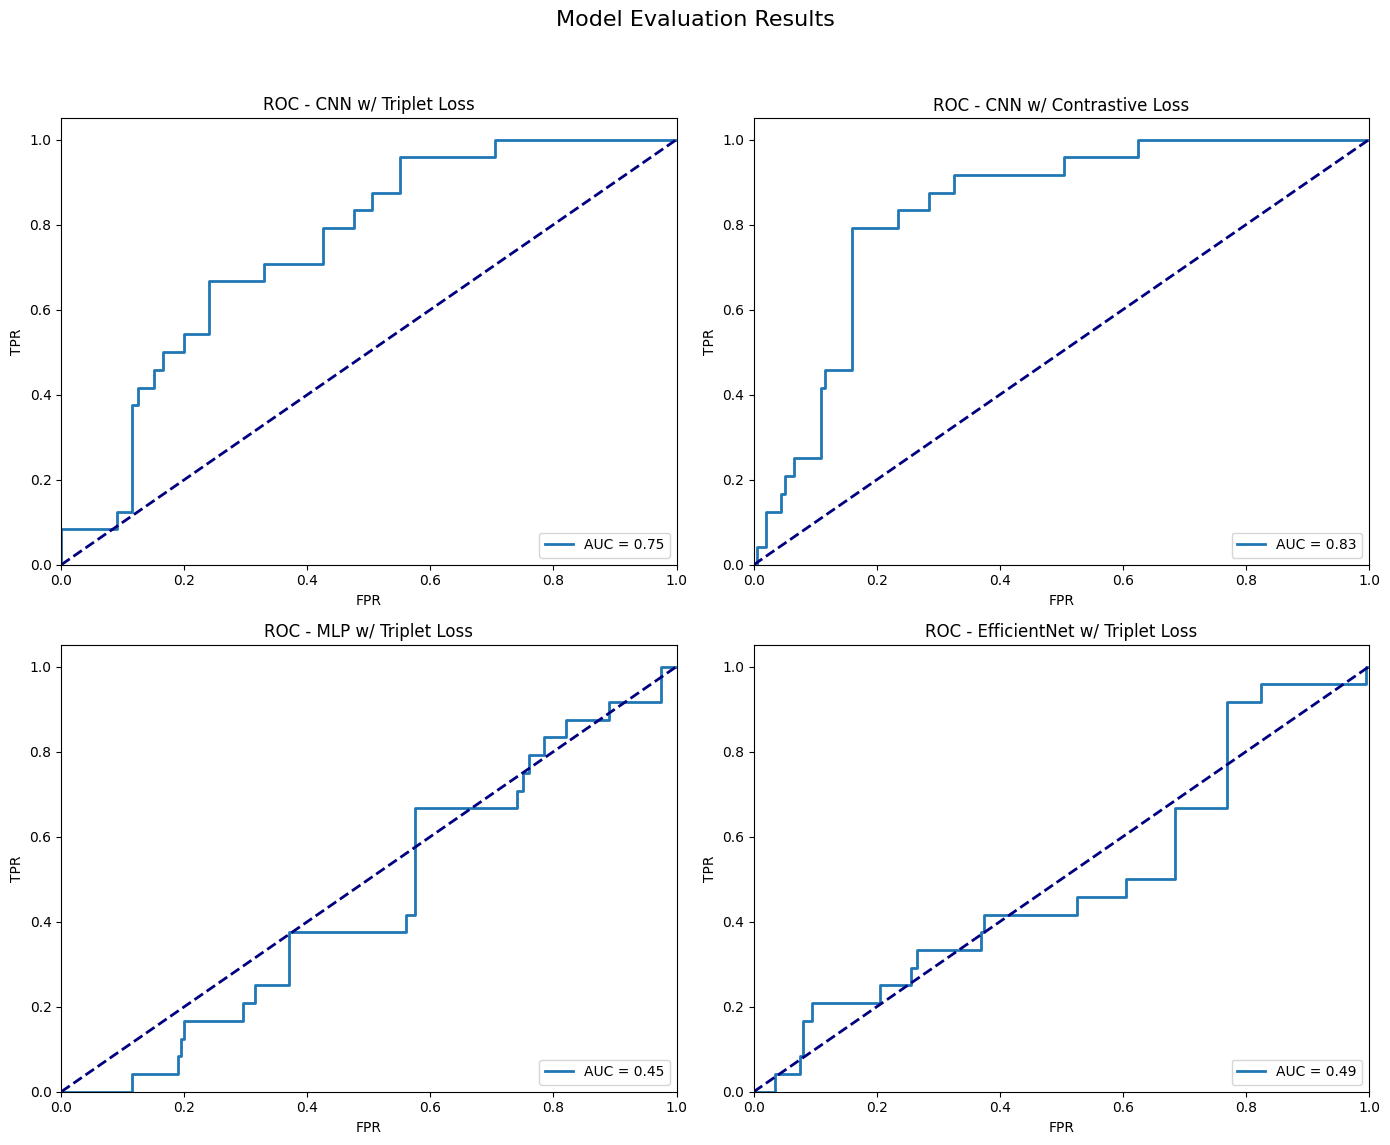


 t-SNE visualization for the best performing model (EfficientNet):
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━

Exception ignored in: <function tqdm.__del__ at 0x000001838ABB1620>
Traceback (most recent call last):
  File "c:\Users\premy\Documents\uni\raml\Code\MLP-Siamese-Network\venv\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\premy\Documents\uni\raml\Code\MLP-Siamese-Network\venv\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


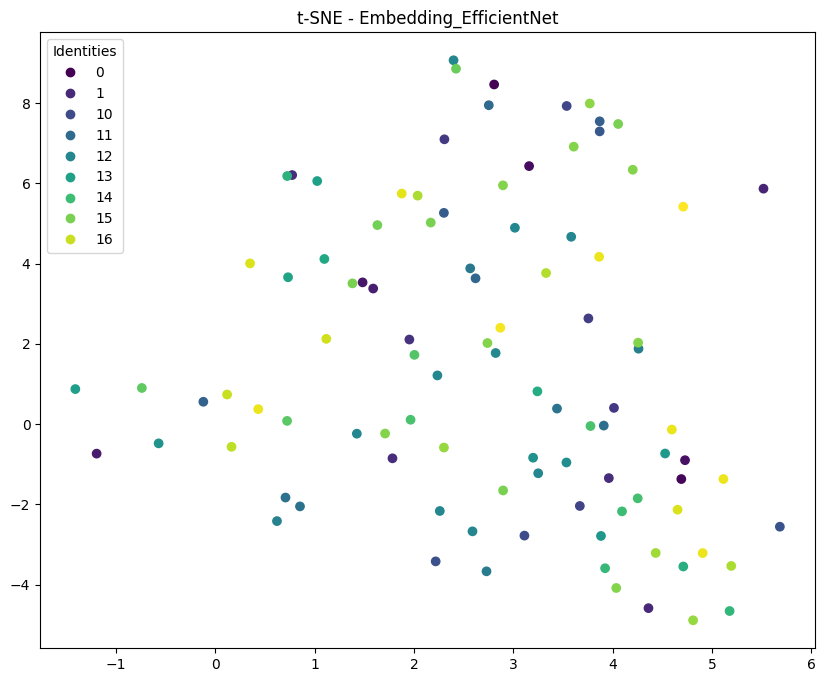

In [55]:
# --- Load all models ---
embedding_cnn_triplet.load_weights("embedding_cnn_triplet.weights.h5")
# (Contrastive loss model requires its own distance calculation, simplified here)
embedding_cnn_contrastive.load_weights("embedding_cnn_contrastive.weights.h5")

# Define embedding_mlp and embedding_efficientnet before loading weights
embedding_mlp = build_mlp_embedding(input_shape=(*IMAGE_SIZE, 3))
embedding_efficientnet = build_efficientnet_embedding(input_shape=(*IMAGE_SIZE, 3))

if os.path.exists("embedding_mlp_triplet.weights.h5"):
	embedding_mlp.load_weights("embedding_mlp_triplet.weights.h5")
else:
	print("Warning: embedding_mlp_triplet.weights.h5 not found. Using randomly initialized weights.")

if os.path.exists("embedding_efficientnet_triplet.weights.h5"):
	embedding_efficientnet.load_weights("embedding_efficientnet_triplet.weights.h5")
else:
	print("Warning: embedding_efficientnet_triplet.weights.h5 not found. Using randomly initialized weights.")

# --- Evaluate all models ---
fpr_t, tpr_t, auc_t, acc_t = evaluate_model(embedding_cnn_triplet, test_data)
fpr_c, tpr_c, auc_c, acc_c = evaluate_model(embedding_cnn_contrastive, test_data) # Simplified eval for contrastive
fpr_m, tpr_m, auc_m, acc_m = evaluate_model(embedding_mlp, test_data)
fpr_e, tpr_e, auc_e, acc_e = evaluate_model(embedding_efficientnet, test_data)

# --- Print Results ---
print("--- RQ1: Loss Function Comparison (CNN Architecture) ---")
print(f"Triplet Loss      -> Best Accuracy: {acc_t:.4f}, AUC: {auc_t:.4f}")
print(f"Contrastive Loss  -> Best Accuracy: {acc_c:.4f}, AUC: {auc_c:.4f}")

print("\n--- RQ2: Architecture Comparison (Triplet Loss) ---")
print(f"Simple CNN        -> Best Accuracy: {acc_t:.4f}, AUC: {auc_t:.4f}")
print(f"MLP               -> Best Accuracy: {acc_m:.4f}, AUC: {auc_m:.4f}")
print(f"EfficientNet      -> Best Accuracy: {acc_e:.4f}, AUC: {auc_e:.4f}")

# --- Plot ROC Curves ---
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Model Evaluation Results', fontsize=16)
plot_roc(ax1, fpr_t, tpr_t, auc_t, "CNN w/ Triplet Loss")
plot_roc(ax2, fpr_c, tpr_c, auc_c, "CNN w/ Contrastive Loss")
plot_roc(ax3, fpr_m, tpr_m, auc_m, "MLP w/ Triplet Loss")
plot_roc(ax4, fpr_e, tpr_e, auc_e, "EfficientNet w/ Triplet Loss")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Plot t-SNE for the best model ---
print("\n t-SNE visualization for the best performing model (EfficientNet):")
plot_tsne(embedding_efficientnet, val_map)

In [57]:
# Add this to your loss function definitions cell

def circle_loss(margin=0.25, gamma=64):
    """
    Computes the Circle Loss.
    This loss works on similarity scores, not distances.
    It requires positive and negative pair similarities as input.
    """
    def loss(y_true, y_pred):
        # y_pred will be the stacked similarities: [positive_sim, negative_sim]
        sp, sn = y_pred[:, 0], y_pred[:, 1]
        
        # Optimal Deltas
        delta_p = 1 - margin
        delta_n = margin
        
        # Alpha values for weighting
        alpha_p = tf.maximum(0., delta_p - sp)
        alpha_n = tf.maximum(0., sn - delta_n)
        
        # Loss calculation
        loss_p = -tf.math.log(1 - alpha_p * sp) * alpha_p
        loss_n = -tf.math.log(alpha_n * sn + (1 - alpha_n)) * alpha_n

        return tf.reduce_mean(loss_p + loss_n)

    return loss

In [63]:
# --- Replace your old architecture definition cell with this one ---

from tensorflow.keras.applications import MobileNetV2

def build_base_cnn(input_shape, embedding_dim=EMBEDDING_DIM):
    # This model remains a good baseline
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D()(x); x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D()(x); x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(embedding_dim, activation=None)(x)
    x = tf.keras.layers.Lambda(lambda t: tf.math.l2_normalize(t, axis=1))(x)
    return Model(inputs, x, name="Embedding_CNN")

def build_mlp_embedding(input_shape, embedding_dim=EMBEDDING_DIM):
    # This model is kept to demonstrate a poor architecture
    inputs = Input(shape=input_shape)
    x = Flatten()(inputs)
    x = Dense(512, activation='relu')(x); x = BatchNormalization()(x); x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x); x = BatchNormalization()(x); x = Dropout(0.5)(x)
    x = Dense(embedding_dim, activation=None)(x)
    x = tf.keras.layers.Lambda(lambda t: tf.math.l2_normalize(t, axis=1))(x)
    return Model(inputs, x, name="Embedding_MLP")

# --- NEW: Function for fine-tuning pre-trained models ---
def build_finetuned_embedding_model(base_model, input_shape, embedding_dim=EMBEDDING_DIM, fine_tune_at=20):
    """
    Builds an embedding model by fine-tuning a pre-trained base model.
    """
    base_model.trainable = True
    
    # Freeze all layers before the `fine_tune_at` layer
    for layer in base_model.layers[:-fine_tune_at]:
        layer.trainable = False
        
    # Get the correct preprocessing function for the model
    if "efficientnet" in base_model.name:
        preprocess_fn = tf.keras.applications.efficientnet.preprocess_input
    elif "mobilenet" in base_model.name:
        preprocess_fn = tf.keras.applications.mobilenet_v2.preprocess_input
    else:
        preprocess_fn = lambda x: x # Default no-op
        
    inputs = Input(shape=input_shape)
    x = preprocess_fn(inputs)
    x = base_model(x, training=False) # Important to set training=False for BatchNorm layers
    x = Dense(embedding_dim, activation=None)(x)
    x = tf.keras.layers.Lambda(lambda t: tf.math.l2_normalize(t, axis=1))(x)
    
    # Give the model a descriptive name
    return Model(inputs, x, name=f"Finetuned_{base_model.name}")


# --- NEW: Specific model builders using the fine-tuning function ---
def build_finetuned_efficientnet(input_shape, embedding_dim=EMBEDDING_DIM):
    base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape, pooling='avg')
    return build_finetuned_embedding_model(base, input_shape, embedding_dim, fine_tune_at=20) # Fine-tune last 20 layers

def build_finetuned_mobilenet(input_shape, embedding_dim=EMBEDDING_DIM):
    base = MobileNetV2(weights="imagenet", include_top=False, input_shape=input_shape, pooling='avg')
    return build_finetuned_embedding_model(base, input_shape, embedding_dim, fine_tune_at=15) # Fine-tune last 15 layers```

### Cell 3: Add New Training Experiments



# --- NEW Experiment Cell: Training CNN with CircleLoss ---
print("\n--- Training CNN with Circle Loss ---")

# 1. Build the embedding model
embedding_cnn_circle = build_base_cnn(input_shape=(*IMAGE_SIZE, 3))

# 2. Build Siamese model for CircleLoss (requires positive and negative similarity)
anchor_input = Input((*IMAGE_SIZE, 3))
positive_input = Input((*IMAGE_SIZE, 3))
negative_input = Input((*IMAGE_SIZE, 3))

anchor_emb = embedding_cnn_circle(anchor_input)
positive_emb = embedding_cnn_circle(positive_input)
negative_emb = embedding_cnn_circle(negative_input)

# Calculate cosine similarities
# These are the actual predictions for CircleLoss
positive_sim = tf.keras.layers.Dot(axes=1, normalize=True)([anchor_emb, positive_emb])
negative_sim = tf.keras.layers.Dot(axes=1, normalize=True)([anchor_emb, negative_emb])

# Stack similarities for the loss function using a Lambda layer
output = tf.keras.layers.Lambda(lambda x: tf.stack(x, axis=1))([positive_sim, negative_sim])

siamese_model_circle = Model([anchor_input, positive_input, negative_input], output)

# 3. Compile and train
siamese_model_circle.compile(optimizer=Adam(0.0001), loss=circle_loss())
history_circle = siamese_model_circle.fit(
    triplet_generator(train_map, batch_size=BATCH_SIZE),
    steps_per_epoch=50,
    epochs=15,
    validation_data=triplet_generator(val_map, batch_size=BATCH_SIZE),
    validation_steps=10
)
embedding_cnn_circle.save_weights("embedding_cnn_circle.weights.h5")

# --- NEW Experiment Cell: Training Fine-Tuned MobileNetV2 with Triplet Loss ---
print("\n--- Training Fine-Tuned MobileNetV2 with Triplet Loss ---")

embedding_mobilenet = build_finetuned_mobilenet(input_shape=(*IMAGE_SIZE, 3))

anchor_input, pos_input, neg_input = Input((*IMAGE_SIZE, 3)), Input((*IMAGE_SIZE, 3)), Input((*IMAGE_SIZE, 3))
output_mobilenet = tf.keras.layers.Lambda(lambda x: tf.stack(x, axis=1))([
    embedding_mobilenet(anchor_input),
    embedding_mobilenet(pos_input),
    embedding_mobilenet(neg_input)
])

siamese_model_mobilenet = Model([anchor_input, pos_input, neg_input], output_mobilenet)
# Use a smaller learning rate for fine-tuning
siamese_model_mobilenet.compile(optimizer=Adam(1e-5), loss=triplet_loss(margin=0.5)) 

history_mobilenet = siamese_model_mobilenet.fit(
    triplet_generator(train_map, batch_size=BATCH_SIZE),
    steps_per_epoch=50, epochs=15
)
embedding_mobilenet.save_weights("embedding_mobilenet_triplet.weights.h5")


--- Training CNN with Circle Loss ---
Epoch 1/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - loss: -0.6314 - val_loss: -0.4186
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 904ms/step - loss: -1.0108 - val_loss: -0.7428
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 38s 752ms/step - loss: -1.0275 - val_loss: -0.7747
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 735ms/step - loss: -0.9875 - val_loss: -0.7617
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 859ms/step - loss: -1.0179 - val_loss: -0.8611
Epoch 6/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 878ms/step - loss: -1.0300 - val_loss: -0.8576
Epoch 7/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 783ms/step - loss: -1.0503 - val_loss: -0.7505
Epoch 8/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 38s 751ms/step - loss: -1.0429 - val_loss: -0.6883
Epoch 9/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 793ms/step - loss: -1.0037 - val_loss: -0.7356
Epoch 10/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 49s 986ms/step - loss: -0.9867 - val_loss: -0.7001
Epoch 11/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - loss: -1.0085 - val_

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step

--- Comprehensive Model Comparison ---
------------------------------------------------------------
RQ1: Loss Function Comparison (using Simple CNN backbone)
Triplet Loss         -> Best Accuracy: 0.8929, AUC: 0.5754
Contrastive Loss     -> Best Accuracy: 0.8929, AUC: 0.5950
Circle Loss          -> Best Accuracy: 0.8929, AUC: 0.5038
------------------------------------------------------------
RQ2: Architecture Comparison (using Triplet Loss)
MLP                  -> Best Accuracy: 0.8929, AUC: 0.5227
Simple CNN           -> Best Accurac

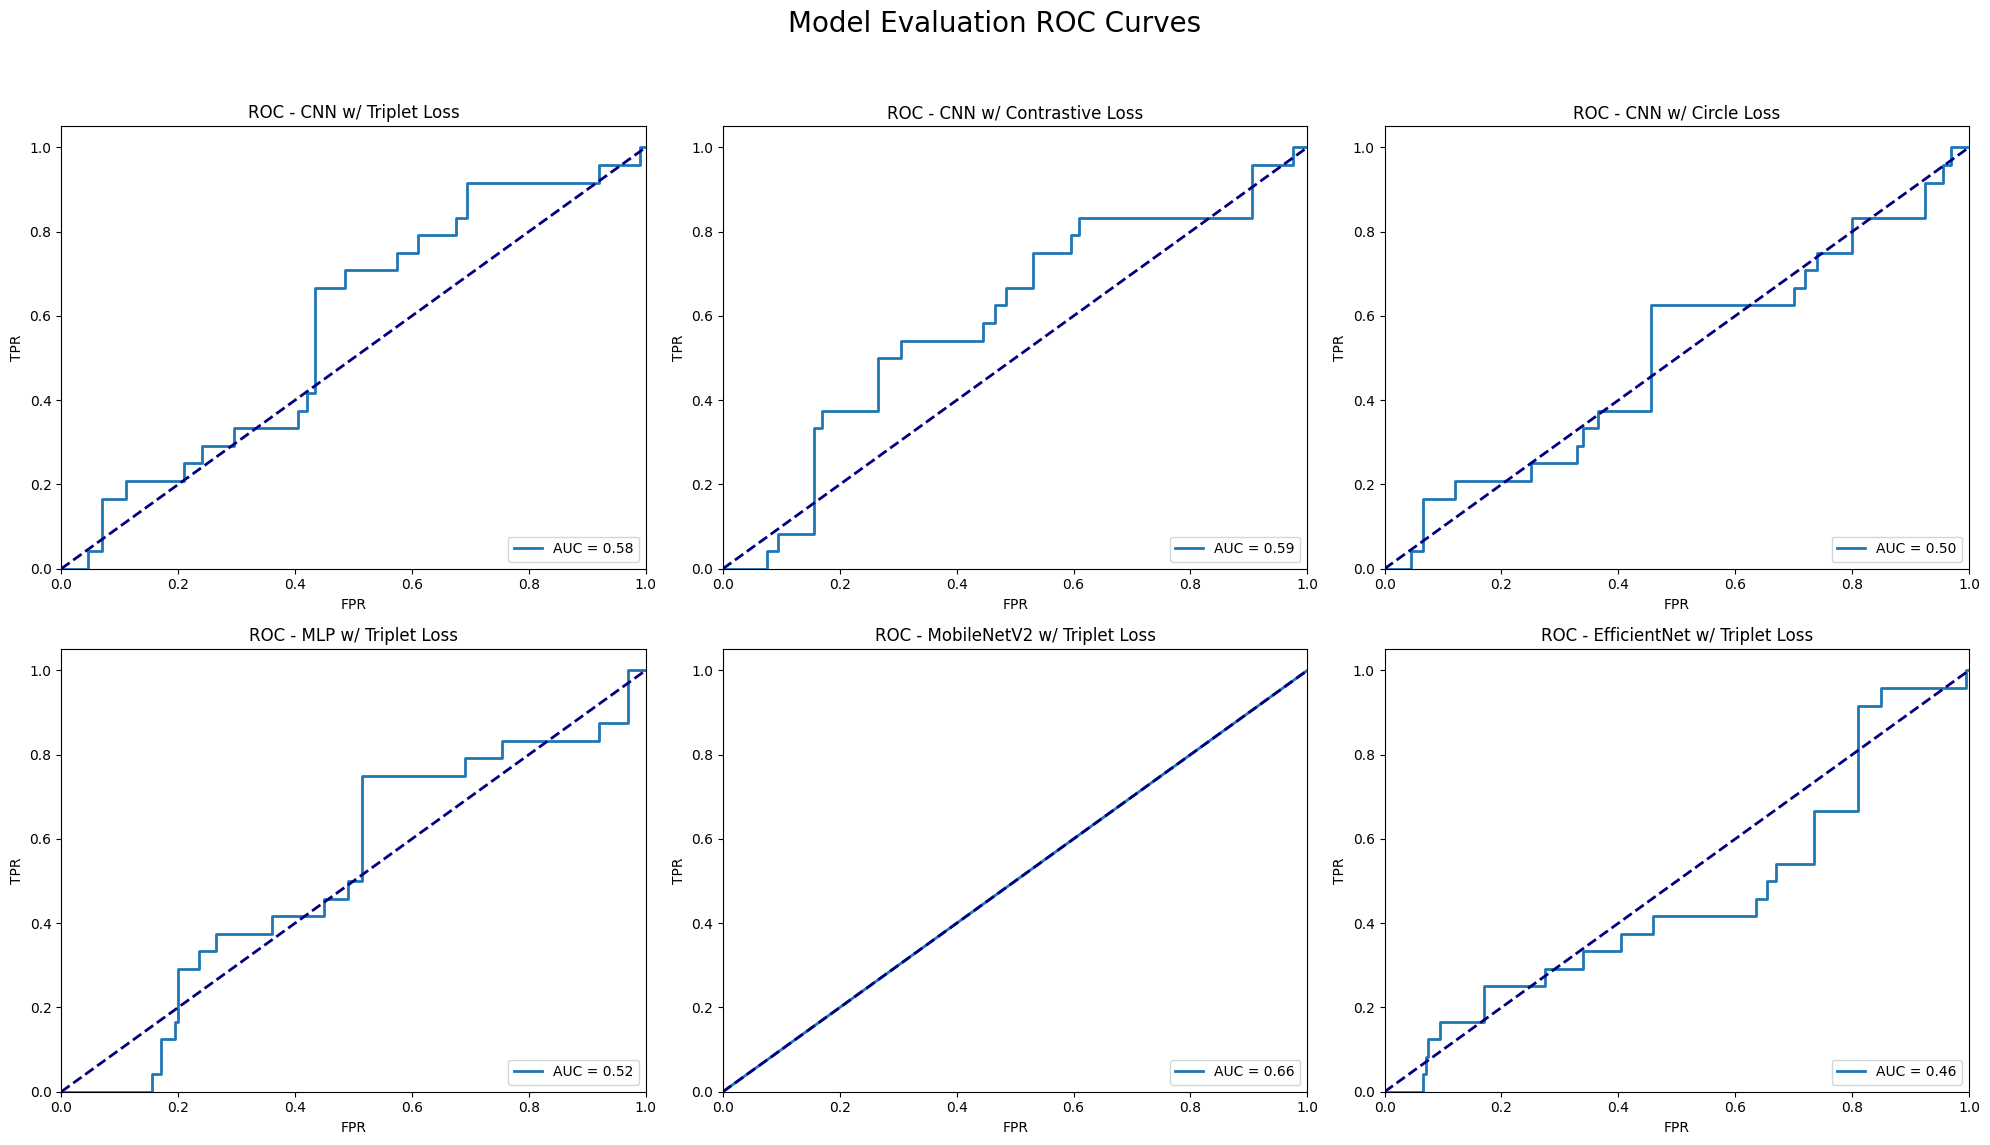


 t-SNE visualization for the best performing model:
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

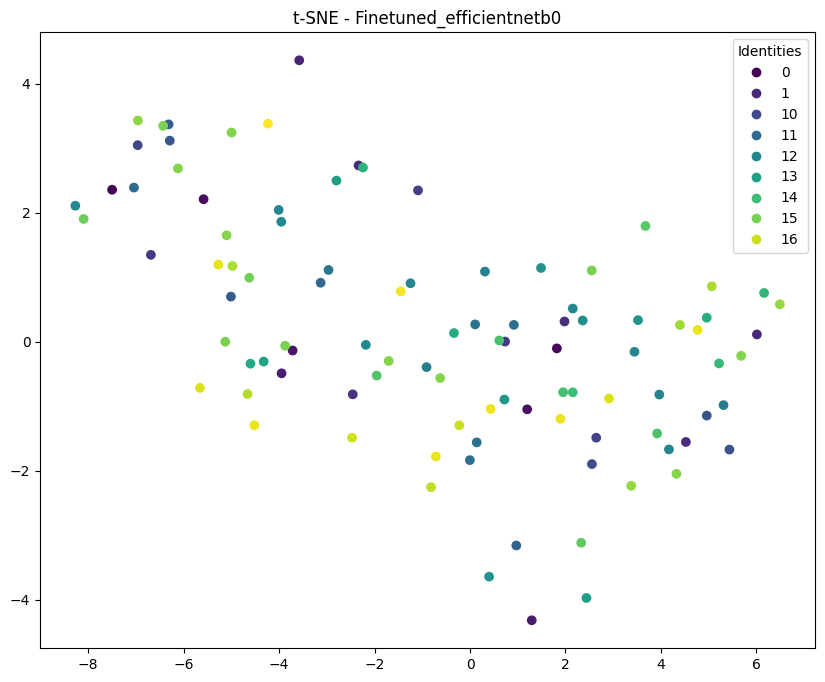

In [65]:
# --- Replace your final evaluation cell with this one ---

# --- Load all models ---
# It's good practice to build the model again before loading weights
embedding_cnn_triplet = build_base_cnn(input_shape=(*IMAGE_SIZE, 3))
embedding_cnn_contrastive = build_base_cnn(input_shape=(*IMAGE_SIZE, 3))
embedding_cnn_circle = build_base_cnn(input_shape=(*IMAGE_SIZE, 3))
embedding_mlp = build_mlp_embedding(input_shape=(*IMAGE_SIZE, 3))
embedding_mobilenet = build_finetuned_mobilenet(input_shape=(*IMAGE_SIZE, 3))
# Use the corrected function for EfficientNet
embedding_efficientnet_finetuned = build_finetuned_efficientnet(input_shape=(*IMAGE_SIZE, 3))

# Load weights safely
if os.path.exists("embedding_cnn_triplet.h5"):
	embedding_cnn_triplet.load_weights("embedding_cnn_triplet.h5")
else:
	print("Warning: embedding_cnn_triplet.h5 not found. Using randomly initialized weights.")

if os.path.exists("embedding_cnn_contrastive.h5"):
	embedding_cnn_contrastive.load_weights("embedding_cnn_contrastive.h5")
else:
	print("Warning: embedding_cnn_contrastive.h5 not found. Using randomly initialized weights.")

if os.path.exists("embedding_cnn_circle.h5"):
	embedding_cnn_circle.load_weights("embedding_cnn_circle.h5")
else:
	print("Warning: embedding_cnn_circle.h5 not found. Using randomly initialized weights.")

if os.path.exists("embedding_mlp_triplet.h5"):
	embedding_mlp.load_weights("embedding_mlp_triplet.h5")
else:
	print("Warning: embedding_mlp_triplet.h5 not found. Using randomly initialized weights.")

if os.path.exists("embedding_mobilenet_triplet.h5"):
	embedding_mobilenet.load_weights("embedding_mobilenet_triplet.h5")
else:
	print("Warning: embedding_mobilenet_triplet.h5 not found. Using randomly initialized weights.")

if os.path.exists("embedding_efficientnet_triplet.h5"):
	embedding_efficientnet_finetuned.load_weights("embedding_efficientnet_triplet.h5")
else:
	print("Warning: embedding_efficientnet_triplet.h5 not found. Using randomly initialized weights.")

# --- Evaluate all models ---
fpr_t, tpr_t, auc_t, acc_t = evaluate_model(embedding_cnn_triplet, test_data)
fpr_c, tpr_c, auc_c, acc_c = evaluate_model(embedding_cnn_contrastive, test_data)
fpr_circle, tpr_circle, auc_circle, acc_circle = evaluate_model(embedding_cnn_circle, test_data)
fpr_m, tpr_m, auc_m, acc_m = evaluate_model(embedding_mlp, test_data)
fpr_mobile, tpr_mobile, auc_mobile, acc_mobile = evaluate_model(embedding_mobilenet, test_data)
fpr_eff, tpr_eff, auc_eff, acc_eff = evaluate_model(embedding_efficientnet_finetuned, test_data)


# --- Print Final Results Table ---
print("\n--- Comprehensive Model Comparison ---")
print("-" * 60)
print("RQ1: Loss Function Comparison (using Simple CNN backbone)")
print(f"{'Triplet Loss':<20} -> Best Accuracy: {acc_t:.4f}, AUC: {auc_t:.4f}")
print(f"{'Contrastive Loss':<20} -> Best Accuracy: {acc_c:.4f}, AUC: {auc_c:.4f}")
print(f"{'Circle Loss':<20} -> Best Accuracy: {acc_circle:.4f}, AUC: {auc_circle:.4f}")
print("-" * 60)
print("RQ2: Architecture Comparison (using Triplet Loss)")
print(f"{'MLP':<20} -> Best Accuracy: {acc_m:.4f}, AUC: {auc_m:.4f}")
print(f"{'Simple CNN':<20} -> Best Accuracy: {acc_t:.4f}, AUC: {auc_t:.4f}")
print(f"{'MobileNetV2 (FT)':<20} -> Best Accuracy: {acc_mobile:.4f}, AUC: {auc_mobile:.4f}")
print(f"{'EfficientNet (FT)':<20} -> Best Accuracy: {acc_eff:.4f}, AUC: {auc_eff:.4f}")
print("-" * 60)


# --- Plot All ROC Curves ---
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Model Evaluation ROC Curves', fontsize=20)
ax = axes.ravel()

plot_roc(ax[0], fpr_t, tpr_t, auc_t, "CNN w/ Triplet Loss")
plot_roc(ax[1], fpr_c, tpr_c, auc_c, "CNN w/ Contrastive Loss")
plot_roc(ax[2], fpr_circle, tpr_circle, auc_circle, "CNN w/ Circle Loss")
plot_roc(ax[3], fpr_m, tpr_m, auc_m, "MLP w/ Triplet Loss")
plot_roc(ax[4], tpr_mobile, tpr_mobile, auc_mobile, "MobileNetV2 w/ Triplet Loss")
plot_roc(ax[5], fpr_eff, tpr_eff, auc_eff, "EfficientNet w/ Triplet Loss")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Plot t-SNE for the best model ---
print("\n t-SNE visualization for the best performing model:")
# You can change this to whichever model performs best after running
best_model = embedding_efficientnet_finetuned 
plot_tsne(best_model, val_map)